# Estimating current cases in Wuhan

#### Author: Yiran Jing
#### Date: Jan 2020

Based on cases detected outside mainland China. **We use Observation on Jan 22**. Since on 2 am Jan 23, Wuhan shut down.


## Conclusion:
- There are at least **4600** (1982.0, 8290.0) cases in Wuhan, until Jan 19. (There is time deley between suspected and confirmed)
- Based on 29 confirmed overseas cases in Jan 26, There are at least more than 16000 cases(11155.0, 23258.0) until Jan 23. 
- **Human migration control** has significant impact on `epidemic growth rate`
***

### Sensitivity analysis: 
Sensitivity analysis to estimate current cases in wuhan based on 4 scenario
1. Baseline
     - **8** overseas confirmed cases until 22 Jan.
     - 10 mean time to detection
     - 19000000 airportCatchment
2. Smaller catchment:
     - airportCatchment = wuhan_population = 11000000
3. Shorter detection window:
     - 8 mean time to detection
4. More exported cases:
     - **29** overseas confirmed cases until 26 Jan.




## Key assumptions:

#### 95% Confidence interval (uncertainty range) represents uncertainty in Epi-based assumptions as well as statistical assumptions

### Epi-based assumptions
1. Unable to estimate the epidemic growth rate
2. Total number of international travel from Wuhan over the last 2 months has been [3301](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/2019-nCoV-outbreak-report-22-01-2020.pdf) per day.
   - This number is based on previous year data, we can calculate more accurately by airport data of 2019
   - This number is 0 after Jan 23 (Wuhan shut down)
3. Estimates donot include cases with mild or no symptoms
4. The incubation period is unknown, and has been approximated by MERS-nCov and SARS.

### Statistical assumptions

1. We assume `independent relationship` between `exported cases` and `confirmed cases` within Wuhan
    - However, exit screening may have reduced exports in recent days
    - Outcome: underestimate of the true number
2. The number of cases detected overseas is **binomially distributed** with Binomial(p), where p is the probability any one caze will be detected overseas. 
    - This assumption only influence the interval estimation
3. Assume international travel is independent of the risk of exposure to 2019n-CoV and infection status. 
    - However, the international traveller might be wealthier people and with lower risk of exposure to 2019n-CoV

***
### Issues uncovered in paper:
1. Consider **Suspected cases** in the model:
    - the cases havenot been confirmed
    - `Time delay`, official under-report
    - Official report there meybe 1000 cases more in Wuhan (Jan 26)
        1. 确诊比例在45%以上,（截止26日，武汉有2209位疑似病例未被检测，643位留院观察）




### Reference: 
1. [Estimating the potential total number of novel Coronavirus cases in Wuhan City, China (Jan 21 2020)](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/2019-nCoV-outbreak-report-22-01-2020.pdf)

In [1]:
import numpy as np
from dataclasses import dataclass
from typing import List
from scipy.stats import nbinom, t
import matplotlib.pyplot as plt
from scipy import stats
import random
import math

In [2]:
class Wuhan:
    """
    Give the basic information of Wuhan, China
    """
    def __init__(self, population:int, airportCatchment:int, internationalTraveller: int):
        # Population of Wuhan
        self.population = population
        # Catchment population in Wuhan international airport 
        self.airportCatchment = airportCatchment
        # Total volume of international travel from Wuhan over last two month (Nov-Dec) per day
        self.internationalTraveller = internationalTraveller
        # Estimated daily probability of international travel
        self.internationalTravelPro = self._calculate_probability_internationalTravel()
    
    def _calculate_probability_internationalTravel(self):
        """
        daily probability of international travel = 
        daily outbound international traveller from Wuhan / catchment population of wuhan airport
        """
        return self.internationalTraveller/self.airportCatchment

class International:
    """
    Info of cases detected outside mainland China
    """
    def __init__(self, cases:int):
    # Number of cases detected outside mainland China
        self.cases = cases  
    
class Coronavirus:
    """
    Give the estimated information of Coronavirus
    """
    def __init__(self, incubation: int, onsetTodetection: int):
        # Estimated incubation period
        self.incubation = incubation
        # Estimated mean time from onset of symptoms to detection
        self.onsetTodetection = onsetTodetection
        # Estimated mean time to detection
        self.detection = self._calculate_detection()
    
    def _calculate_detection(self):
        """
        mean time to detection = incubation period + mean time from onset of symptoms to detection
        """
        return self.incubation + self.onsetTodetection
    
@dataclass    
class Estimate_wuhan_case:
    model_name: str
    date: str
    wuhan: Wuhan
    international: International
    coronavirus: Coronavirus
    
    def __str__(self): 
        """
        Representation
        """
        return f"""{self.date} 
Scenario: {self.model_name}
Exported number of confirmed cases: {self.international.cases}
Detection Window: {self.coronavirus.detection}
Time from onset of symptoms to detection: {self.coronavirus.onsetTodetection}
Daily International passengers travelling out of Wuhan: {self.wuhan.internationalTraveller}
Effective catchment population of Wuhan Interntional Airport: {self.wuhan.airportCatchment}

Estimated number of cases in Wuhan: {self.calculate_total_cases_inWuhan()}
Estimated 95% confidence interval: {self.calculate_conf_interval()}

------------------------------------------------------------------------------------
"""
    
    def calculate_total_cases_inWuhan(self):
        """
        total_cases_inWuhan = 
           number of cases detected overseas / probability anyone case will be detected overseas
        """
        p = self.calculate_pro_detected_overseas() # probability anyone case will be detected overseas
        return self.international.cases / p
    
    def calculate_pro_detected_overseas(self):
       """
       probability anyone case will be detected overseas = 
           daily probability of international travel * mean time to detection of a case
       """
       return self.wuhan.internationalTravelPro * self.coronavirus.detection
    
    def calculate_conf_interval(self, alpha=0.05):
        """
        Calculate confidence interval by MLE:
           Suppose population follows binomial distribution Bin(p,N)
           p: probability anyone case will be detected overseas
           N: negative binomially distributed function of X (number of cases detected outside mainland China)
           
        Notes:
          by CLT negative binomial distribution will be approximately normal if the parameter N is large enough
        """
        p = self.calculate_pro_detected_overseas()
        n = self.international.cases
        mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
        
        # Lower bound of 95% density dist
        lb = nbinom.ppf((alpha/2), n, p)  
        # Upper bound of 95% density dist
        ub = nbinom.ppf((1-alpha/2), n, p) 
        return (lb, ub) # incorrect !!! ❌
        #margin = stats.norm.ppf(1-alpha/2)*np.sqrt(var)
        #return (mean-margin, mean+margin)
    
    def plot_distribution(self):
        """
        Plot the distrubution of estimated Coronavirus cases in Wuhan 
        """
        p = self.calculate_pro_detected_overseas()
        n = self.international.cases
        
        fig, ax = plt.subplots(1, 1)
        x = np.arange(nbinom.ppf(0.025, n, p),
                   nbinom.ppf(0.975, n, p))
        ax.vlines(x, 0, nbinom.pmf(x, n, p), color='lightblue', lw=5, alpha=0.5)
        ax.set_title(self.date + " Estimated number of coronavirus cases in Wuhan")

@dataclass
class Estimate_Period:
    collect: List[Estimate_wuhan_case] # collect time series

2019-01-21 
Scenario: Baseline
Exported number of confirmed cases: 7
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 19000000

Estimated number of cases in Wuhan: 4029.0820963344436
Estimated 95% confidence interval: (1615.0, 7507.0)

------------------------------------------------------------------------------------



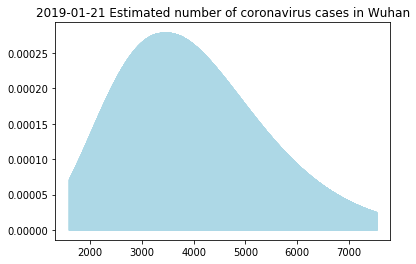

In [3]:
# Baseline
wuhan_case_Jan21 = Estimate_wuhan_case(model_name = 'Baseline', date = '2019-01-21', 
                                      wuhan = Wuhan(population=11000000, 
                                                    airportCatchment=19000000, 
                                                    internationalTraveller=3301),
                                      international = International(cases = 7),
                                      coronavirus = Coronavirus(incubation=6, 
                                                                onsetTodetection=4))

print(wuhan_case_Jan21)
# Plot the distrubution of estimated Coronavirus cases in Wuhan 
wuhan_case_Jan21.plot_distribution()

## Sensitivity Analysis
Sensitivity analysis to estimate current cases in wuhan based on 4 scenario
1. Baseline
     - **8** overseas confirmed cases until 22 Jan.
     - 10 mean time to detection
     - 19000000 airportCatchment
2. Smaller catchment:
     - airportCatchment = wuhan_population = 11000000
3. Shorter detection window:
     - 8 mean time to detection
4. More exported cases:
     - **29** overseas confirmed cases until 26 Jan.


In [4]:
def sensitivity_analysis(date: str, wuhan_population: int,
                        airportCatchment: int, international_case: int, onsetTodetection: int,
                        incubation=6, internationalTraveller=3301):
    """
    Sensitivity analysis to estimate current cases in wuhan based on 4 scenario
    1. Baseline
    2. Smaller catchment:
        airportCatchment = wuhan_population
    3. Shorter detection window:
    4. More exported cases:
         The real international case 29 overseas confirmed cases until 26 Jan.
    """
    # scenario cases
    scenarios = ['Baseline', 'Smaller catchment', 'Shorter detection window', 'Exported cases Jan 26']
    Catchment_old = airportCatchment
    onsetTodetection_old = onsetTodetection
    international_case_old = international_case
    
    for scenario in scenarios:
        if scenario == 'Smaller catchment':
            airportCatchment=wuhan_population
        elif scenario == 'Shorter detection window':
            onsetTodetection = 2
        elif scenario == 'Exported cases Jan 26':
            international_case = 29 
            
            
        wuhan_case = Estimate_wuhan_case(model_name = scenario, date = date, 
                                wuhan = Wuhan(population=wuhan_population, 
                                              airportCatchment=airportCatchment, 
                                              internationalTraveller=internationalTraveller),
                                international = International(cases = international_case),
                                coronavirus = Coronavirus(incubation=incubation, 
                                                          onsetTodetection=onsetTodetection))
        # plot                                                      
        # wuhan_case.plot_distribution()    
        
        # print model information
        print(wuhan_case)
        
        # convert to original 
        airportCatchment = Catchment_old
        onsetTodetection = onsetTodetection_old
        international_case = international_case_old

In [6]:
# 8 exported cases until Jan 22 
# 29 exported cases until Jan 26 
sensitivity_analysis(date='2019-01-22', wuhan_population=11000000,
                        airportCatchment=19000000,international_case=8, onsetTodetection=4)

2019-01-22 
Scenario: Baseline
Exported number of confirmed cases: 8
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 19000000

Estimated number of cases in Wuhan: 4604.6652529536495
Estimated 95% confidence interval: (1982.0, 8290.0)

------------------------------------------------------------------------------------

2019-01-22 
Scenario: Smaller catchment
Exported number of confirmed cases: 8
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 11000000

Estimated number of cases in Wuhan: 2665.8588306573765
Estimated 95% confidence interval: (1145.0, 4795.0)

------------------------------------------------------------------------------------

2019-01-22 
Scenario: Shorter detection window
Exported number of con

In [5]:
# CI is incorrect (lower than the paper) 
sensitivity_analysis(date='2019-01-21', wuhan_population=11000000,
                     airportCatchment=19000000,international_case=7, 
                     onsetTodetection=4)

2019-01-22 
Scenario: Baseline
Exported number of confirmed cases: 8
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 19000000

Estimated number of cases in Wuhan: 4604.6652529536495
Estimated 95% confidence interval: (1982.0, 8290.0)

------------------------------------------------------------------------------------

2019-01-22 
Scenario: Smaller catchment
Exported number of confirmed cases: 8
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 11000000

Estimated number of cases in Wuhan: 2665.8588306573765
Estimated 95% confidence interval: (1145.0, 4795.0)

------------------------------------------------------------------------------------

2019-01-22 
Scenario: Shorter detection window
Exported number of con